# Projet Recherche Opérationelle - Branch And Bound

## Introduction

Lors de ce projet nous nous sommes penchés sur l'implémentation de l'algorithme de branch-and-bound pour un problème d'ordonnancement étudié en TD (présentation détaillée problème ci dessous). Outre la mise en pratique des connaissances aquises au cours de ce semestre, ce projet nous aura permis une compréhension plus fine de cet algorithme, en travaillant nottament sur chaque composante de l'algorithme : 
* sa règle de branchement 
* sa méthode d'exploration 
* le calcul de ses bornes (primales et duales)


__Le problème considéré :__

Un atelier de production doit usiner un ensemble $J=\{1,\dots,n\}$ de pièces. Pour cela, l'atelier possède une machine unique. Chaque pièce $j \in J$ nécessitera $p_j$ unités de temps pour être usinée. Nous supposons que l'on se trouve à la date t=0 et chaque pièce $j \in J$ doit être prête à la date $d_j$. Si cette date n'est pas respectée, l'usine devra payer une pénalité $w_j$ par unité de temps de retard. Il s'agit donc d'un __problème de minimisation__ dans lequel nous devons déterminer l'ordre de passage des pièces sur la machine qui peremttra de minimiser les pénalités de retard.

__Le plan du projet :__

* __Structures de données__

Choix des différentes structures utiles pour l'algorithme et pour définir les instances du problème. 

* __Déclaration externe de méthodes utiles pour branch and bound__ 

Implémentation de diverses méthodes utiles lors de l'implémentation de l'algorithme de branch and bound. 

* __Travail sur les composantes de branch and bound__ 

Nous implémentons différentes méthodes de calcul de bornes primales et duales ainsi que différentes méthodes d'exploration de l'arbre de branchement. Nous étudierons l'effet de ces différentes méthodes sur les performances de l'algorithme.

* __Algorithme de branch and bound__ 

Nous implémentons l'algorithme de branch and bound. 

* __Choix des composantes du branch and bound__

Nous testons l'influence de chaque composante sur les performances du Branch and bound.

* __Evaluation du Branch and Bound__ 

Nous vérifions que l'Algorithme renvoie bien le cout minimum en comparant ses sorties et celles d'une résolution du problème par PLNE. Nous étudions les performances de l'algorithme en fonction du nombre d'instance d'un problème.

* __Visualisation de l'arbre de branchement__

Nous implémentons ici une méthode de visualisation de l'arbre de branchement.

* __Atelier à plusieurs machines__

Pour aller plus loin, nous considérons une extension du problème. 





## Importation des modules

Nous importons tout d'abord tous les modules nécessaires dans ce projet. Nous utilisons les modules classiques __numpy__ et __matplotlib (pyplot)__. Nous utilisons égalements les modules __networkx__ et un module particulier de pydot (cellule pour installation ci dessous) lors de la visualisation de parcours de l'arbre de branchement.

conda install pydot

In [67]:
import numpy as np
import math
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib import pyplot as plt
import copy
import time
from pulp import *

## Structure de données

*Nous définissons un certain nombre de structures de données, liées au problème ou à l'algorithme de Branch and Bound.*

### Les instances du problème

Le problème possède 3 données clefs : 
* le nombre d'unités de temps nécessaire à l'usinage de chaque pièce
* la date d'usinage a laquelle chque pièce doit être usinée
* la pénalité de retard associée à chaque pièce

Nous faisons le choix d'utiliser des listes pour stocker ces 3 instances du problème. Un problème donné sera donc caractérisé par 3 listes : 
* une liste __p__
* une liste __d__
* une liste __w__

### Les noeuds 

Chaque noeud de l'arbre de branchement sera un objet. Chaque objet Noeud créé possède :
* Un indexe : __idx__
* Un noeud parent : __parent__
* Une liste de noeuds enfants : __children__
* Une borne duale associée (lower bound ici, puisqu'il s'agit d'un problème de minimisation) : __lb__
* Une liste de noeuds visités : __visited__.
* Une méthode d'affichage.

Dans cette première partie, les index de noeuds seront des entiers, leur stockage sera rapide. Dans la partie __affichage__ les index seront des chaines de caractères plus ou moins longues, leur stockage sera légèrement plus long.

__Exemple__

![Arbre de branchement](EX2.png)

En considérant que les noeud en vert on déjà été visités et que les noeuds rouges ne l'ont pas été, le noeud 1 représenté ci dessus possèderait (selon la structure choisie) les éléments suivants : 
* __idx__=1
* __parent__=0
* __children__=[ 4 , 5 ]
* __visited__=[ 0 ]

In [2]:
class Node:
    
    def __init__(self,idx, parent, children, lb, visited):
        self.idx = idx
        self.parent = parent
        self.children = children
        self.lb = lb
        self.visited = visited
        
    def __str__(self):
        return ("Parent : " +str(self.parent)+
                "\n Children : "+str(self.children) + 
                "\n lb : "+str(self.lb)+ 
                "\n visited : "+str(self.visited))

## Déclaration externe de fonctions utiles pour branch and bound

### Fonctions abroresence et computeCost

*Nous implémentons à présent un certain nombre de fonctions que nous utiliserons lors de l'implémentation de l'algorithme de branch and bound.*

La première fonction est une fonction arborescence. Elle nous permet de donner une branche complète d'arbre de branchement en partant d'une feuille. Dans l'__exemple__ ci-dessus, la fonction : __arborescence(4,Tree)__ renverrait : [4,1,0]. 

Afin de déterminer facilement le cout d'une solution donnée, nous implémentons une méthode générale computeCost. A partir des données du problème (p,d,w) et d'un ordre de taches à effectuer, la fonction renvoie le cout de la solution.

In [3]:
def arborescence(node,Tree):
    branch = []
    while node.parent != None:
        branch.append(node)
        node = Tree[node.parent]
    branch.append(node)
    
    return branch

In [4]:
def computeCost(p,d,w,order):
    t=0
    cost=0
    for idx in order:
        t += p[idx]
        cost += max(0,(t-d[idx])*w[idx])
    return cost

Afin de tester la dernière méthode nous utilisons le problème vu en TD (*exercice 7, TD branch and bound*) dont les instances sont rappelées ci-dessous : 

* unités de temps pour que les pièces soient usinées : p=[12,8,15,9]
* date auxquelles les pièces doivent être prêtes : d=[16,26,25,27]
* pénalités de retard : w=[4,5,3,5]

In [5]:
p = [12,8,15,9]
d = [16,26,25,27]
w = [4,5,3,5]

La solution que nous testons (ordre d'usinage : [0,1,3,2]) est la solution optimale, obtenue lors du TD. Son coût vaut 67. On vérifie donc que la fonction computeCost nous donne bien 67 avec cet ordre d'usinage.

In [6]:
computeCost(p,d,w,[0,1,3,2])

67

## Travail sur les composantes de Branch and Bound

### Calculs de bornes primales

L'idée de ce projet est de tester différentes composantes de l'algorithme de Branch and Bound, afin de voir leur impact sur les performances de l'algorithme. 

Nous nous concentrons tout d'abord sur le calcul des bornes primales. Le calcul de borne primale s'effectue au début de l'algorithme. Plus le calcul est fin, i.e plus la borne primale obtenue possède une valeur faible, plus l'algorithme ira vite. En effet, une borne primale assez faible permettra d'élaguer plus rapidement des branches et donc de parcourir moins de noeuds.
L'idée est donc d'essayer de trouver la méthode la plus interessante.


Nous avons fait le choix de coder différentes fonctions :
* __getPrimal_0__ : nous calculons une solution en usinant les pièces selon l'ordre croissant des dates d'usinage au plus tard.


* __getPrimal_1__ : nous calculons une solution en usinant les pièces selon l'ordre croissant des (dates d'usinage au plus tard-le temps d'usinage)$*$pénalité
Comme les premières pièces engendrent le moins de retard, nous nous sommes dit qu'il est possible d'obtenir une meilleure borne primale en réflechissant à la position des derniers éléments. Cela nous a amené à la fonction : 


* __getPrimal_2__ : nous calculons une solution en mettant à la dernière position disponible l'élément non traité donnant lieu à la plus petite pénalité de retard.

In [7]:
def getPrimal_0(p,d,w):
    sortedTasks = np.argsort(d)
    cost = computeCost(p,d,w,sortedTasks)
    return(cost,sortedTasks)


def getPrimal_1(p,d,w):
    sortedTasks = (np.argsort((np.array(d)-np.array(p))*np.array(w)))[::-1]
    cost = computeCost(p,d,w,sortedTasks)
    return(cost,sortedTasks)


def getPrimal_2(p,d,w):
    tasksLeft = [int(i) for i in range(len(p))]
    order = []
    while len(tasksLeft)!= 0:
        time = np.sum(np.array(p)[tasksLeft])
        penalities = (time-np.array(d)[tasksLeft])*np.array(w)[tasksLeft]
        sortedTasks = np.argsort(penalities)
        order.append(tasksLeft[sortedTasks[0]])
        tasksLeft.pop(sortedTasks[0])
    order.reverse()
    cost = computeCost(p,d,w,order)
    return(cost,order)

In [8]:
print("Temps production : ", p)
print("Date limite :      ", d)
print("Pénalités :        ", w)
print("0 : ",getPrimal_0(p,d,w))
print("1 : ",getPrimal_1(p,d,w))
print("2 : ",getPrimal_2(p,d,w))

Temps production :  [12, 8, 15, 9]
Date limite :       [16, 26, 25, 27]
Pénalités :         [4, 5, 3, 5]
0 :  (136, array([0, 2, 1, 3]))
1 :  (133, array([3, 1, 2, 0]))
2 :  (67, [0, 1, 3, 2])


### Calcul des bornes duales

Nous nous concentrons maintenant sur le calcul des bornes duales. Le calcul de bornes duales s'effectue à chaque ajout d'un nouveau noeud dans l'arbre. Ces bornes duales constituent le coeur de l'algorithme du Branch and Bound, et plus le calcul sera rapide ou les bornes de qualité, plus l'algorithme sera efficace.  
Encore une fois, comme les premières pièces engendrent le moins de retard, nous définissons deux "types" de fonctions de calcul de bornes duales : Un calcul qui calcule ces bornes pour des pièces placées en début de planning, et une pour des pièces placées en fin de planning.

L'idée est donc d'essayer de trouver la méthode la plus interessante.

Nous avons donc codé les 3 fonctions suivantes : 

* __getDual_0__ : Si on a fixé l'ordre de $k$ pièces on calcule les pénalités de retard de ces $k$ pièces et on ajoute les pénalités des autres pièces en supposant qu'elles sont en $(k+1)$ème position. (Dans le cas où les $k$ pièces sont positionnées aux positions $[1,2,\ldots,k-1,k]$)


* __getDual_1__ : Si on a fixé l'ordre de $k$ pièces on calcule les pénalités de retard de ces $k$ pièces. (Dans le cas où les $k$ pièces sont positionnées aux positions $[1,2,\ldots,k-1,k]$)


* __getDual_2__ : Si on a fixé l'ordre de $k$ pièces on calcule les pénalités de retard de ces $k$ pièces. (Dans le cas où les $k$ pièces sont positionnées aux positions $[n-k+1, n-k+2,\ldots, n-1,n]$)

In [9]:
def getDual_0(p,d,w,visited):
    dual=0
    time=0
    notVisited=list(range(len(p)))
    for i in visited:
        retard=((p[i]+time)-d[i])
        dual+=retard*w[i]*(retard>0)
        time+=p[i]
        notVisited.remove(i)
        
    for j in notVisited:
        retard=(p[j]+time)-d[j]
        dual+=retard*w[j]*(retard>0)
    return dual

def getDual_1(p,d,w,visited):
    dual = 0
    time = 0
    notVisited = list(range(len(p)))
    for i in visited:
        retard = ((p[i]+time)-d[i])
        dual += retard*w[i]*(retard>0)
        time += p[i]
        notVisited.remove(i)
    return dual

def getDual_2(p,d,w,visited):
    dual = 0
    time = np.sum(p)
    for i in visited:
        retard = (time-d[i])
        dual += retard*w[i]*(retard>0)
        time -= p[i] 
    return dual

In [10]:
p = [12,8,15,9]
d = [16,26,25,27]
w = [4,5,3,5]

print("Temps production : ", p)
print("Date limite :      ", d)
print("Pénalités :        ", w)
print("0 : ", getDual_0(p,d,w,[0,1]))
print("1 : ", getDual_1(p,d,w,[1]))

Temps production :  [12, 8, 15, 9]
Date limite :       [16, 26, 25, 27]
Pénalités :         [4, 5, 3, 5]
0 :  40
1 :  0


__Note :__  Afin de mieux comprendre ce qu'implique le choix d'une des deux méthodes et comment elle permet de dérouler l'arbre, nous proposerons des fonctions de visualisation qui permettront d'observer la construction de ce dernier.

### Méthodes d'exploration

Finalement, nous allons essayer différentes méthodes d'exploration de l'arbre de décision : 

* __exploration_0__ : "Breadth First" - Parcours en largeur de l'arbre. 

Cette méthode explorera tous les noeuds d'un niveau de l'arbre avant de passer au suivant.

* __exploration_1__ : "Depth First" - Parcours en profondeur de l'arbre. 

Contrairement à la méthode précédente, cette méthode d'exploration va parcourir les branches en intégralité avant de remonter. Cette approche est à priori profitable puisque elle permet d'ajuster plus rapidement $z_P$ et donc de plus rapidement élaguer des branches de l'arbre.

* __exploration_2__ : "Best First" - Meilleur d'abord. 



In [11]:
def exploration_0(Queue,Tree,UB):
    return(Queue[0])

def exploration_1(Queue,Tree,UB):
    return(Queue[-1])

def exploration_2(Queue,Tree,UB):
    bestNode = Queue[-1]
    bestLB = -math.inf
    for idx in Queue:
        if Tree[idx].lb > bestLB and Tree[idx].lb < UB:
            bestLB = Tree[idx].lb
            bestNode = idx
    return(bestNode)

## Branch and Bound

Nous allons ici décrire le fonctionnement de notre algorithme de _Branch and Bound_ qui sera au coeur de notre projet. Afin de facilement comparer les performances de nos différentes approches et de leurs méthodes associées, nous avons décidé de faire un algorithme le plus général possibles. Ses entrées sont les suivantes : 

__Entrées :__

* __p :__ Donnée du problème : Temps de production de chaque pièce à usiner.

* __d :__ Donnée du problème : Date limite de production de chaque pièce à usiner. Chaque pièce dont la production se terminera après cette date entraînera une pénalité de retard. 

* __w :__ Donnée du problème : Poids associé à la pénalité de retard. Dans un contexte d'entreprise, certains retards seront "moins importants" que d'autres. Une pièce très importante aura un poids associé à sa pénalité de retard très élevé.

* __byLast :__ Booléen : Indique si les pièces sont ajoutées par la fin (=_True_)(_Méthode 2_) ou par le début (=_False_)(_Méthode 1_). Cette option n'aura pas beaucoup d'impact sur notre algorithme, elle permettra cependant de bien penser à inverser l'ordre des pièces avant d'utiliser notre fonction calculant le coût de l'ordonnancement proposé. 

* __getPrimal :__ Fonction utilisateur :  Fonction calculant la première borne primale au début de l'algorithme. Passer cet argument sous forme de fonction nous permettra de comparer diférentes approches sans avoir à coder un nouvel algorithme de _Branch and Bound_.

* __getDual :__ Fonction utilisateur :  Fonction caculant les bornes duales à chaque noeud de l'arbre. L'intérêt de passer cet argument en paramètre est le même que pour _getPrimal_.

* __exploration :__ Fonction utilisateur :  Fonction retournant le prochain noeud à visiter à chaque étape de l'algorithme.

__Sorties :__

* __UB :__ Solution du problème.

* __currentOrder :__ Ordonnancement associé à cette solution.

* __nbIterations :__ Nombre d'itérations de l'algorithme avant de retourner la solution.

* __branch :__ Liste des noeuds remontant du noeud solution jusqu'au noeud racine (Utilisé pour surligner la solution sur l'affichage de l'arbre de branchement).

* __Tree :__ Arbre de branchement final.

In [12]:
def branch_and_bound(p,d,w,byLast,getPrimal,getDual,exploration):
    
    Tasks = list(range(len(p)))
    Tree = [] # list of all nodes created (a list of Node objects)
    Queue = [] # list of nodes to process (a list of integers with the index of nodes to process in the Tree)
    LB = 0 # best Lower Bound of the problem 
    
    UB,currentOrder = getPrimal(p,d,w) #We start by computing the first primal/upper bound.

    bestNode = Node(-1,-1, [], 0 ,[]) #default best node
    
    root = Node(0,None, [], 0, []) # define the root node of the tree
    Tree.append(root) # start the tree with the root node
    Queue.append(0) # start the list of nodes to process with the root node
    
    #continue processing nodes until the queue is empty
    
    nbIterations = 0
    
    while len(Queue)!=0 :
        
        # process the nodes in the queue according to the chosen exploration method
        
        currentIndex = exploration(Queue,Tree,UB)
        currentNode = Tree[currentIndex]
        nbIterations += 1
        
        if currentNode.lb < UB:
            
            # If the processed node corresponds to a "full-schedule" we check whether this solution is an improvement or not
            # If so, we update the problem Upper Bound / best order / best node
            
            if len(currentNode.visited) == len(p):
                order = copy.copy(currentNode.visited)
                if byLast:
                    order.reverse()
                solutionCost = computeCost(p,d,w,order)
                if solutionCost <= UB:
                    UB = solutionCost
                    currentOrder = order
                    bestNode = currentNode
            else:
                
                #for each task not processed yet we create a new node
                for nextTask in (set(Tasks)-set(currentNode.visited)):
                    nextVisited = copy.copy(currentNode.visited)
                    nextVisited.append(nextTask)
                    nextLb = getDual(p,d,w, nextVisited)

                    newNode = Node(len(Tree),currentIndex, [], nextLb,nextVisited)
                    Tree.append(newNode)
                    Queue.append(len(Tree)-1)
                    currentNode.children.append(len(Tree)-1)
            
        # When the processing of the node is completed remove the node from the queue     
        Queue.remove(currentIndex)

    # return the  solution
    
    if (UB-bestNode.lb)<=0.0001:
        branch = arborescence(bestNode,Tree)
    
    # If the best node is not a leaf, the bestNode variable is still the default one default
    else:
        bestLB = -math.inf
        for node in Tree:
            if node.lb > bestLB and node.lb <=UB:
                bestLB = node.lb
                bestNode=node
        branch = arborescence(bestNode,Tree)

    return UB, currentOrder, nbIterations, branch, Tree

## Choix des composantes du Branch and Bound

*Nous mettons en place plusieurs tests afin de comparer les performances de nos différentes méthodes de calcul de bornes, des méthodes d'exploration, et de notre algorithme sur des problèmes de différentes tailles*

### Bornes duales, Bornes primales, Méthode d'exploration : 

Comme décrit plus haut, nous avons codé différentes fonction pour le calcul de bornes primales et de bornes duales, ainsi que différentes méthodes d'exploration de l'arbre de _Branch and Bound_. Nous comparerons ces différentes méthodes de la manière suivante : 

* __Bornes Primales :__ La comparaison des méthodes de calcul de bornes primales sera assez simple. En effet plus la valeur trouvée est petite plus la méthode est efficace. Nous comparerons donc les valeurs moyennes des bornes primales trouvées sur différentes instances aléatoires avec chacune de nos fonctions.


* __Bornes Duales :__ La comparaison des méthodes de calcul de bornes duales ne se fera pas sur la valeur de ces dernières, mais directement sur la performance de l'agorithme. Nos différentes méthodes correspondent à deux règles de branchement et impliquent des parcours de l'arbre différent, avec un ajout des pièces _"croissant"/"décroissant"_. Nous comparerons le nombre d'itérations et le temps d'exécution nécessaire à l'obtention d'une solution.


* __Méthodes d'exploration :__ Nous avons proposé trois méthodes d'exploration de l'arbre de _Branch and Bound_ différentes. nous observerons les implication du choix de chacune de ces méthodes sur le nombre d'itérations et le temps d'exécution de l'algorithme.

### Instances aléatoires : 

*Avant d'entamer les tests de performances, nous introduisons un générateur d'instances*

Nous définissons ci-dessous une fonction qui nous permettra de générer des instances aléatoires de problèmes d'ordonnancement. Cette fonction nous permettra de comparer les performances de nos différentes approches sur des problèmes de taille choisie.

Plus le paramètre alpha diminue et plus les dates limites sont rapprochées, et donc le problème difficile. 

*Par la suite nous règlerons souvent le paramètre alpha à 0.3 pour être sûrs d'avoir des hors délais*

In [45]:
def genInstancies(n,alpha):
    p=np.random.randint(1,15,n)
    d=np.random.randint(3,int(alpha*n*15),n)
    w=np.random.randint(1,5,n)
    return(p,d,w)

Un exemple aléatoire  : 

In [46]:
p,d,w = genInstancies(8,.3)
print("Temps production : ", p)
print("Date limite :      ", d)
print("Pénalités :        ", w)

Temps production :  [11  4  6  7 13  1  4  1]
Date limite :       [30 13 30 30 34  4 20  5]
Pénalités :         [2 3 1 2 1 4 2 3]


### Choix de la méthode de calcul pour les bornes primales

__Rappel__: plus une fonction de calcul de borne primale est performante, plus la valeur de la borne primale trouvée est petite.

* __Exemple du cours__ 

In [13]:
p = [12,8,15,9]
d = [16,26,25,27]
w = [4,5,3,5]

Comparons les résultats des méthodes de calcul de bornes primales sur cet exemple (*EX7 TD branch and bound*)

In [49]:
print("Temps production : ", p)
print("Date limite :      ", d)
print("Pénalités :        ", w)
print("Borne primale obtenue avec getPrimal_0 : ",getPrimal_0(p,d,w)[0])
print("Borne primale obtenue avec getPrimal_1 : ",getPrimal_1(p,d,w)[0])
print("Borne primale obtenue avec getPrimal_2 : ",getPrimal_2(p,d,w)[0])

Temps production :  [11  4  6  7 13  1  4  1]
Date limite :       [30 13 30 30 34  4 20  5]
Pénalités :         [2 3 1 2 1 4 2 3]
Borne primale obtenue avec getPrimal_0 :  21
Borne primale obtenue avec getPrimal_1 :  351
Borne primale obtenue avec getPrimal_2 :  17


__Conclusion :__ sur cet exemple, la méthode getPrimal_2 est bien plus performante que les méthodes 0 et 1.

* __Exemple aléatoire__

In [50]:
p,d,w = genInstancies(8,.3)

Comparons les résultats des méthodes de calcul de bornes primales sur cet exemple en utilisant la méthode get_dual_2 et ce pour les 3 méthodes d'exploration implémentées auparavant. Nous étudierons également l'influence de ces méthodes sur le nombre d'itérations de l'algorithme de Branch and Bound.

In [51]:
#DFS
start_0 = time.time()
solution_0, order_0, nbIterations_0, branch_0, Tree = branch_and_bound(p,d,w, True, getPrimal_0, getDual_2,exploration_1)
end_0 = time.time()
start_1 = time.time()
solution_1, order_1, nbIterations_1, branch_1, Tree = branch_and_bound(p,d,w, True, getPrimal_1, getDual_2,exploration_1)
end_1 = time.time()
start_2 = time.time()
solution_2, order_2, nbIterations_2, branch_2, Tree = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
end_2 = time.time()

print("Depth First")
print("getPrimal         0 | 1  | 2")
print("Primal Bound   : {} | {} | {}".format(getPrimal_0(p,d,w)[0],getPrimal_1(p,d,w)[0],getPrimal_2(p,d,w)[0]))
print("Solution       : {} | {} | {}".format(solution_0,solution_1,solution_2))
print("nbIterations   : {} | {} | {}".format(nbIterations_0,nbIterations_1,nbIterations_2))
print("Execution time : {} | {} | {}".format(end_0-start_0,end_1-start_1,end_2-start_2))

#BFS
start_0 = time.time()
solution_0, order_0, nbIterations_0, branch_0, Tree = branch_and_bound(p,d,w, True, getPrimal_0, getDual_2,exploration_0)
end_0 = time.time()
start_1 = time.time()
solution_1, order_1, nbIterations_1, branch_1, Tree = branch_and_bound(p,d,w, True, getPrimal_1, getDual_2,exploration_0)
end_1 = time.time()
start_2 = time.time()
solution_2, order_2, nbIterations_2, branch_2, Tree = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_0)
end_2 = time.time()

print("\n\nBreadth First")
print("getPrimal         0 | 1  | 2")
print("Primal Bound   : {} | {} | {}".format(getPrimal_0(p,d,w)[0],getPrimal_1(p,d,w)[0],getPrimal_2(p,d,w)[0]))
print("Solution       : {} | {} | {}".format(solution_0,solution_1,solution_2))
print("nbIterations   : {} | {} | {}".format(nbIterations_0,nbIterations_1,nbIterations_2))
print("Execution time : {} | {} | {}".format(end_0-start_0,end_1-start_1,end_2-start_2))

Depth First
getPrimal         0 | 1  | 2
Primal Bound   : 245 | 245 | 209
Solution       : 122 | 122 | 122
nbIterations   : 2138 | 2138 | 2127
Execution time : 0.14166522026062012 | 0.09795784950256348 | 0.07236266136169434


Breadth First
getPrimal         0 | 1  | 2
Primal Bound   : 245 | 245 | 209
Solution       : 122 | 122 | 122
nbIterations   : 47412 | 47412 | 28755
Execution time : 3.2460219860076904 | 3.412277936935425 | 2.055267095565796


__Résultat :__ Encore une fois, la méthode $getPrimal\_2$ semble être la plus efficace. 

Notons également que le choix de la méthode de calcul de borne primale est corrélé au nombre d'itérations de l'algorithme de branch and bound :

* lorsque l'on utilise un parcours en largeur, le nombre d'itérations varie régulièrement du simple au centuple entre l'exécution démarrée avec $getPrimal\_2$ et celle avec $getPrimal\_1$. Une meilleure borne primale permet de rapidement élaguer des noeuds en haut de l'arbre et ainsi de réduire considérablement le temps d'exécution. 

* lorsque l'on utilise un parcours en profondeur, cette différence est moins marquée puisque l'algorithme va de lui même aller mettre à jour cette borne primale assez rapidement. On observe quand même régulièrement des nombres d'itérations allant du simple au double entre $getPrimal\_2$ et $getPrimal\_1$.

* __Valeurs de bornes primales sur un grand nombre d'instances aléatoires__

Comme le titre l'indique, nous comparons ici les performances des méthodes de calcul de bornes primales pour de nombreuses instances aléatoires. L'idée est simple : générer 100 valeurs de bornes primales pour des problèmes de taille 4 à 12, puis calculer la valeur moyenne de la borne primale obtenue avec chaque méthode.

In [52]:
N = int(1e3) #Nombre d'échantillons
n = 12 #Taille maximum du problème
resultats_0 = [[] for i in range(4,n)]
resultats_1 = [[] for i in range(4,n)]
resultats_2 = [[] for i in range(4,n)]
for _ in range(N):
    for i in range(4,n):
        p,d,w = genInstancies(i,.3)
        resultats_0[i-4].append(getPrimal_0(p,d,w)[0])
        resultats_1[i-4].append(getPrimal_1(p,d,w)[0])
        resultats_2[i-4].append(getPrimal_2(p,d,w)[0])
resultats_0 = [np.mean(res) for res in resultats_0]
resultats_1 = [np.mean(res) for res in resultats_1]
resultats_2 = [np.mean(res) for res in resultats_2]

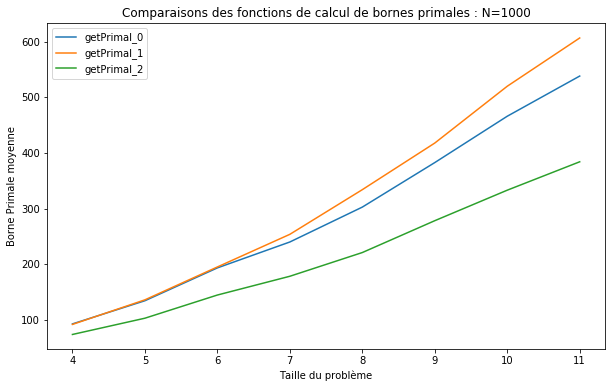

In [53]:
plt.figure(figsize=(10,6))
X = list(range(4,n))
plt.plot(X,resultats_0, label="getPrimal_0")
plt.plot(X,resultats_1, label="getPrimal_1")
plt.plot(X,resultats_2, label="getPrimal_2")
plt.legend()
plt.xlabel("Taille du problème")
plt.ylabel("Borne Primale moyenne")
plt.title("Comparaisons des fonctions de calcul de bornes primales : N={}".format(N))
plt.show()

__Conclusion :__ Comme nous avions pu le présager avec les tests précédents, la fonction $getPrimal\_2$ donne de meilleurs résultats que $getPrimal\_0$, qui sont toutes les deux bien meilleures que $getPrimal\_1$. 

Par la suite, nous utiliserons ainsi majoritairement $getPrimal\_2$ par défaut pour la comparaison des autres fonctions et les tests de performances. 

### Choix de la méthode d'exploration 

Nous utiliserons maintenant la méthode de calcul de bornes primales $getPrimal\_2$ et comparerons les nombre d'itérations de l'algorithme pour Breadth First, Depth First et Best First  avec les méthodes getDual_0,getDual_1 et getDual_2.

* __Exemple de cours__

In [54]:
p = [12,8,15,9]
d = [16,26,25,27]
w = [4,5,3,5]

In [55]:
solution_0, order_0, nbIterations_0, branch_0, Tree = branch_and_bound(p,d,w, False, getPrimal_2, getDual_0,exploration_0)
solution_1, order_1, nbIterations_1, branch_1, Tree = branch_and_bound(p,d,w, False, getPrimal_2, getDual_1,exploration_0)
solution_2, order_2, nbIterations_2, branch_2, Tree = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_0)
print("Breadth First")
print("getDual         0 | 1  | 2")
print("Solution     : {} | {} | {}".format(solution_0,solution_1,solution_2))
print("nbIterations : {} | {} | {}".format(nbIterations_0,nbIterations_1,nbIterations_2))

Breadth First
getDual         0 | 1  | 2
Solution     : 67 | 67 | 67
nbIterations : 23 | 59 | 8


In [56]:
solution_0, order_0, nbIterations_0, branch_0, Tree = branch_and_bound(p,d,w, False, getPrimal_2, getDual_0,exploration_1)
solution_1, order_1, nbIterations_1, branch_1, Tree = branch_and_bound(p,d,w, False, getPrimal_2, getDual_1,exploration_1)
solution_2, order_2, nbIterations_2, branch_2, Tree = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
print("Depth First")
print("getDual         0 | 1  | 2")
print("Solution     : {} | {} | {}".format(solution_0,solution_1,solution_2))
print("nbIterations : {} | {} | {}".format(nbIterations_0,nbIterations_1,nbIterations_2))

Depth First
getDual         0 | 1  | 2
Solution     : 67 | 67 | 67
nbIterations : 23 | 59 | 8


In [57]:
solution_0, order_0, nbIterations_0, branch_0, Tree = branch_and_bound(p,d,w, False, getPrimal_2, getDual_0,exploration_2)
solution_1, order_1, nbIterations_1, branch_1, Tree = branch_and_bound(p,d,w, False, getPrimal_2, getDual_1,exploration_2)
solution_2, order_2, nbIterations_2, branch_2, Tree = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_2)
print("Best First")
print("getDual         0 | 1  | 2")
print("Solution     : {} | {} | {}".format(solution_0,solution_1,solution_2))
print("nbIterations : {} | {} | {}".format(nbIterations_0,nbIterations_1,nbIterations_2))

Best First
getDual         0 | 1  | 2
Solution     : 67 | 67 | 67
nbIterations : 23 | 59 | 8


__Conclusion :__ Nous ne remarquons pas de différences entre les méthodes d'exploration "Breadth First / Depth First / Best First". 

Notons aussi que sur cet exemple, la méthode de branchement "inverse" avec getDual_2 semble bien plus efficace que les deux autres méthodes.

* __Instances aléatoires__

Après n'avoir trouvé aucune différence de nombre d'itérations entre les différentes méthodes sur l'exemple vu en TD, nous allons comparer les méthodes sur des instances aléatoires de taille raisonnable et ajoutant un nouvel élément de comparaison : le temps d'exécution.

In [58]:
p,d,w = genInstancies(7,.3)


start = time.time()
solution_0, order_0, nbIterations_0, branch_0, Tree = branch_and_bound(p,d,w, False, getPrimal_2, getDual_0,exploration_1)
solution_1, order_1, nbIterations_1, branch_1, Tree = branch_and_bound(p,d,w, False, getPrimal_2, getDual_1,exploration_1)
solution_2, order_2, nbIterations_2, branch_2, Tree = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
end = time.time()
print("Depth First")
print("getDual           0 | 1  | 2")
print("Solution       : {} | {} | {}".format(solution_0,solution_1,solution_2))
print("nbIterations   : {} | {} | {}".format(nbIterations_0,nbIterations_1,nbIterations_2))
print("Execution time :", end-start)


start = time.time()
solution_0, order_0, nbIterations_0, branch_0, Tree = branch_and_bound(p,d,w, False, getPrimal_2, getDual_0,exploration_0)
solution_1, order_1, nbIterations_1, branch_1, Tree = branch_and_bound(p,d,w, False, getPrimal_2, getDual_1,exploration_0)
solution_2, order_2, nbIterations_2, branch_2, Tree = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_0)
end = time.time()
print("\nBreadth First")
print("getDual           0 | 1  | 2 ")
print("Solution       : {} | {} | {}".format(solution_0,solution_1,solution_2))
print("nbIterations   : {} | {} | {}".format(nbIterations_0,nbIterations_1,nbIterations_2))
print("Execution time :", end-start)

start = time.time()
solution_0, order_0, nbIterations_0, branch_0, Tree = branch_and_bound(p,d,w, False, getPrimal_2, getDual_0,exploration_2)
solution_1, order_1, nbIterations_1, branch_1, Tree = branch_and_bound(p,d,w, False, getPrimal_2, getDual_1,exploration_2)
solution_2, order_2, nbIterations_2, branch_2, Tree = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_2)
end = time.time()
print("\nBest First : ")
print("getDual           0 | 1  | 2 ")
print("Solution       : {} | {} | {}".format(solution_0,solution_1,solution_2))
print("nbIterations   : {} | {} | {}".format(nbIterations_0,nbIterations_1,nbIterations_2))
print("Execution time :", end-start)

Depth First
getDual           0 | 1  | 2
Solution       : 170 | 170 | 170
nbIterations   : 879 | 9048 | 210
Execution time : 0.387814998626709

Breadth First
getDual           0 | 1  | 2 
Solution       : 170 | 170 | 170
nbIterations   : 1168 | 9592 | 382
Execution time : 0.41092395782470703

Best First : 
getDual           0 | 1  | 2 
Solution       : 170 | 170 | 170
nbIterations   : 906 | 8843 | 286
Execution time : 35.396148920059204


__Conclusion :__ Si on ne s'intéresse qu'au nombre d'itérations, les méthodes d'exploration "Depth First" et "Best First" semblement surpasser la méthode "Breadth First". En effet, on obtient quasiment systématiquement un nombre d'itérations plus important avec cette dernière et ce pour les raisons que nous avons évoquées auparavant: Le parcours en profondeur permet de plus rapidement mettre à jour la valeur de $z_P$ et donc d'élaguer plus rapidement des branches. 

Cependant, lorsque l'on s'intéresse aux temps d'éxécution, c'est bien la méthode "Best First" qui est la moins efficace. Elle s'exécute en un nombre d'itérations plus faible que la méthode "Breadth First" mais chaque itération est beaucoup plus coûteuse et son temps d'exécution est largement supérieur à celui des deux autres. Ainsi, cette méthode d'exploration sera à bannir sur de plus grandes instances.

* __Comparaison des méthodes sur un nombre d'instances aléatoires élevé__


__1)Temps d'exécution__

In [59]:
N = int(1e2) #Nombre d'échantillons
n = 7 #Taille maximum du problème
resultats_0 = [[] for i in range(3,n)]
resultats_1 = [[] for i in range(3,n)]
resultats_2 = [[] for i in range(3,n)]
for _ in range(N):
    for i in range(3,n):
        p,d,w = genInstancies(i,.3)
        
        start_0 = time.time()
        _, _, _, _, _ = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_0)
        end_0 = time.time()
        
        start_1 = time.time()
        _, _, _, _, _ = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
        end_1 = time.time()
        
        start_2 = time.time()
        _, _, _, _, _ = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_2)
        end_2 = time.time()
        
        resultats_0[i-3].append(end_0-start_0)
        resultats_1[i-3].append(end_1-start_1)
        resultats_2[i-3].append(end_2-start_2)
        
resultats_0 = [np.mean(res) for res in resultats_0]
resultats_1 = [np.mean(res) for res in resultats_1]
resultats_2 = [np.mean(res) for res in resultats_2]

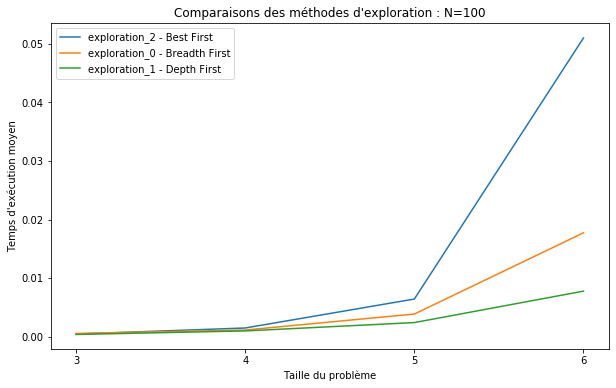

In [60]:
plt.figure(figsize=(10,6))
X = list(range(3,n))
plt.plot(X,resultats_2, label="exploration_2 - Best First")
plt.plot(X,resultats_0, label="exploration_0 - Breadth First")
plt.plot(X,resultats_1, label="exploration_1 - Depth First")
plt.legend()
plt.xlabel("Taille du problème")
plt.xticks(X)
plt.ylabel("Temps d'exécution moyen")
plt.title("Comparaisons des méthodes d'exploration : N={}".format(N))
plt.show()

__2)Nombre d'itérations__

In [61]:
N = int(1e2) #Nombre d'échantillons
n = 7 #Taille maximum du problème
resultats_0 = [[] for i in range(3,n)]
resultats_1 = [[] for i in range(3,n)]
resultats_2 = [[] for i in range(3,n)]
for _ in range(N):
    for i in range(3,n):
        p,d,w = genInstancies(i,.3)
        _, _, nbIterations_0, _, _ = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_0)
        _, _, nbIterations_1, _, _ = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
        _, _, nbIterations_2, _, _ = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_2)
        
        resultats_0[i-3].append(nbIterations_0)
        resultats_1[i-3].append(nbIterations_1)
        resultats_2[i-3].append(nbIterations_2)
        
resultats_0 = [np.mean(res) for res in resultats_0]
resultats_1 = [np.mean(res) for res in resultats_1]
resultats_2 = [np.mean(res) for res in resultats_2]

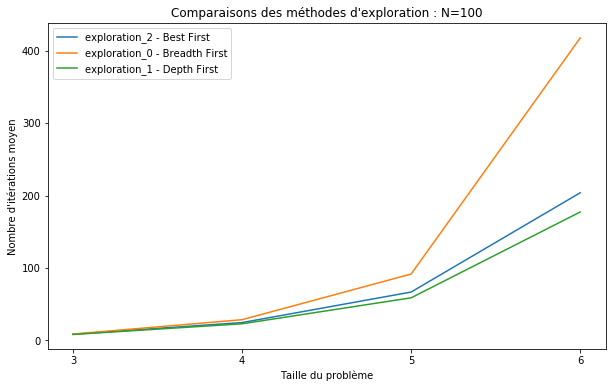

In [62]:
plt.figure(figsize=(10,6))
X = list(range(3,n))
plt.plot(X,resultats_2, label="exploration_2 - Best First")
plt.plot(X,resultats_0, label="exploration_0 - Breadth First")
plt.plot(X,resultats_1, label="exploration_1 - Depth First")
plt.legend()
plt.xlabel("Taille du problème")
plt.ylabel("Nombre d'itérations moyen")
plt.xticks(X)
plt.title("Comparaisons des méthodes d'exploration : N={}".format(N))
plt.show()

__Conclusion :__ Que ce soit en termes de temps d'exécution, ou en termes des nombre d'itérations, la méthode d'exploration la plus performante semble être la méthode _Depth First_. La méthode _Best First_ est assez similaire en nombre d'itérations mais chaque itération étant beaucoup plus longue, son temps d'exécution est largement supérieur. Finalement, la méthode _Breadth First_ est toujours moins bonne que la méthode _Depth First_, bien que cette différence soit moins flagrante en termes de temps d'exécution.

Comme évoqué précédemment, la méthode _Depth First_ permet de plus rapidement mettre à jour la valeur de la borne primale du problème et ainsi d'élaguer plus rapidement les noeuds, ce qui a pour conséquence de réduire le nombre d'itérations de l'algorithme et ainsi son temps d'exécution.

__Nous utiliserons donc la méthode "Depth First" pour la suite.__

### Choix de la méthode de calcul de bornes duales

Maintenant que nous savons quelles méthodes de caclul de bornes primales et d'exploration utiliser, nous allons pouvoir nous attaquer au coeur du problème et comparer les performances de nos différentes approches du problème ou règles de branchement avec le calcul des bornes duales.

Pour rappel, les méthodes $getDual\_0$ et $getDual\_1$ correspondent à un ajout des tâches par le début et la fonction $getDual\_2$ correspond à un ajout des tâches en commençant par la fin.

* __getDual_0__ : Si on a fixé l'ordre de $k$ pièces on calcule les pénalités de retard de ces $k$ pièces et on ajoute les pénalités des autres pièces en supposant qu'elles sont en $(k+1)$ème position. (Dans le cas où les $k$ pièces sont positionnées aux positions $[1,2,\ldots,k-1,k]$).


* __getDual_1__ : Si on a fixé l'ordre de $k$ pièces on calcule les pénalités de retard de ces $k$ pièces. (Dans le cas où les $k$ pièces sont positionnées aux positions $[1,2,\ldots,k-1,k]$).


* __getDual_2__ : Si on a fixé l'ordre de $k$ pièces on calcule les pénalités de retard de ces $k$ pièces. (Dans le cas où les $k$ pièces sont positionnées aux positions $[n-k+1, n-k+2,\ldots, n-1,n]$).

* __Comparaison des méthodes sur un grand nombre d'instances aléatoires__

__1) Temps d'exécution__

In [63]:
N = int(1e2) #Nombre d'échantillons
n = 7 #Taille maximum du problème
resultats_0 = [[] for i in range(3,n)]
resultats_1 = [[] for i in range(3,n)]
resultats_2 = [[] for i in range(3,n)]
resultats_3 = [[] for i in range(3,n)]
for _ in range(N):
    for i in range(3,n):
        p,d,w = genInstancies(i,.3)
        
        start_0 = time.time()
        _, _, _, _, _ = branch_and_bound(p,d,w, False, getPrimal_2, getDual_0,exploration_1)
        end_0 = time.time()
        
        start_1 = time.time()
        _, _, _, _, _ = branch_and_bound(p,d,w, False, getPrimal_2, getDual_1,exploration_1)
        end_1 = time.time()
        
        start_2 = time.time()
        _, _, _, _, _ = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
        end_2 = time.time()
        
        resultats_0[i-3].append(end_0-start_0)
        resultats_1[i-3].append(end_1-start_1)
        resultats_2[i-3].append(end_2-start_2)
        
resultats_0 = [np.mean(res) for res in resultats_0]
resultats_1 = [np.mean(res) for res in resultats_1]
resultats_2 = [np.mean(res) for res in resultats_2]

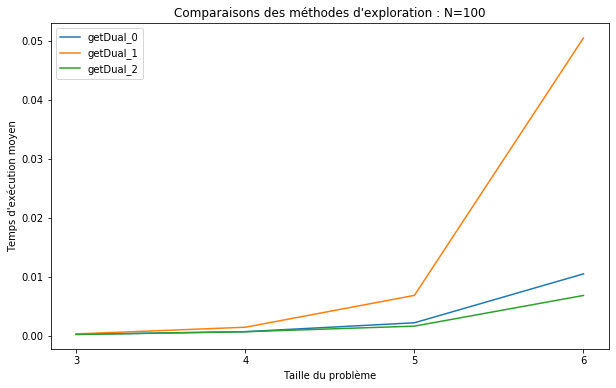

In [64]:
plt.figure(figsize=(10,6))
X = list(range(3,n))
plt.plot(X,resultats_0, label="getDual_0")
plt.plot(X,resultats_1, label="getDual_1")
plt.plot(X,resultats_2, label="getDual_2")
plt.legend()
plt.xlabel("Taille du problème")
plt.xticks(X)
plt.ylabel("Temps d'exécution moyen")
plt.title("Comparaisons des méthodes d'exploration : N={}".format(N))
plt.show()

__2) Nombre d'itérations__

In [65]:
N = int(1e2) #Nombre d'échantillons
n = 7 #Taille maximum du problème
resultats_0 = [[] for i in range(3,n)]
resultats_1 = [[] for i in range(3,n)]
resultats_2 = [[] for i in range(3,n)]
resultats_3 = [[] for i in range(3,n)]
for _ in range(N):
    for i in range(3,n):
        p,d,w = genInstancies(i,.3)
        _, _, nbIterations_0, _, _ = branch_and_bound(p,d,w, False, getPrimal_2, getDual_0,exploration_1)
        _, _, nbIterations_1, _, _ = branch_and_bound(p,d,w, False, getPrimal_2, getDual_1,exploration_1)
        _, _, nbIterations_2, _, _ = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
        
        resultats_0[i-3].append(nbIterations_0)
        resultats_1[i-3].append(nbIterations_1)
        resultats_2[i-3].append(nbIterations_2)
        
resultats_0 = [np.mean(res) for res in resultats_0]
resultats_1 = [np.mean(res) for res in resultats_1]
resultats_2 = [np.mean(res) for res in resultats_2]

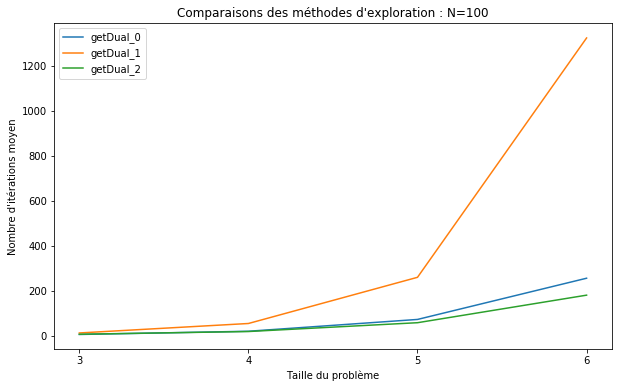

In [66]:
plt.figure(figsize=(10,6))
X = list(range(3,n))
plt.plot(X,resultats_0, label="getDual_0")
plt.plot(X,resultats_1, label="getDual_1")
plt.plot(X,resultats_2, label="getDual_2")
plt.legend()
plt.xlabel("Taille du problème")
plt.ylabel("Nombre d'itérations moyen")
plt.xticks(X)
plt.title("Comparaisons des méthodes d'exploration : N={}".format(N))
plt.show()

__Résultats :__ Comme précédemment, on observe que la règle de branchement qui consiste à ajouter les tâches en partant de la fin est bien plus efficace que celle qui les ajoute au début. 


Sans grandes surprises, la méthode $getDual\_0$ est plus performante que la méthode $getDual\_1$. En effet la première donnera toujours des bornes duales supérieures à la deuxième, étant donné qu'elle prend en compte les pénalités de retard des pièces déjà placées mais aussi de celles qui ne sont pas encore placées mais qui auront forcément du retard.


L'algorithme de Branch and Bound est plus performant avec la méthode $getDual\_2$ qu'avec la méthode $getDual\_0$. C'est donc cette fonction que nous utiliserons pour comparer les performances du _Branch and Bound_ sur des problèmes de taille variée.

### Bilan 

Afin d'optimiser les performance de l'algorithme de Branch and Bound, nous utiliserons les méthodes : 
* __getPrimal_2__
* __getDual_2__
* __exploration_1__

## Test de l'algorithme de _Branch and Bound_ sur des problèmes de tailles différentes

Nous réalisons ici plusieurs tests de notre algorithme : nous vérifions d'abord que l'algorithme fonctionne, puis étudions ses performances. 

### Comparaison avec un PLNE 

Dans un premier temps, il est nécessaire de voir si l'algorithme est fonctionnel, i.e si il renvoie bien une solution de cout minimal. Pour vérfier cela, nous implémentons la résolution du même problème d'ordonnancement par l'intermédiaire d'un PLNE, et comparons les valeurs obtenues via l'algorithme de Branch&Bound, et celles obtenues par l'intermédiaire du PLNE. 

Soit $J$ l'ensemble des pièces à usiner. 

__Variables :__

* $r_j$ est le retard d'usinage de la pièce j.
* $f_j$ est "le temps"/"la date" à laquelle est usinée la pièce j.
* $x_{ij}\in \{0,1\}$, =1 ssi la pièce i est usinée avant la pièce j.

__Fonction objectif :__ 

* on veut minimiser le cout total des pénalités de retard : min$\underset{j\in J}{\sum} w_jr_j$

__Contraintes :__
* le retard d'usinage de chaque pièce correspond à sa date de fabrication - la date d a laquele elle doit être prête : $r_j \geq f_j-d_j$, $~~~~~\forall j \in J$
* le retard d'usinage de chaque pièce est positif ou nul : $r_j \geq 0$, $~~~~~\forall j \in J$
* la date de fin d'usinage de chaque pièce correspond au temps nécessaire pour usiner les pièces précédentes + le temps d'usinage de la pièce considérée : $f_j=p_j+\underset{\underset{i\neq j}{i \in J}}{\sum} p_ix_{ij}$, $~~~~~\forall j \in J$
* Si la pièce i est usinée avant la pièce j, alors j ne peut pas être usinée avant i :$x_{ij}+x_{ji}=1$, $~~~~~\forall (i,j) \in J^2,~~i<j$
* Transitivité : si i est usinée avant j et j est usinée avant k, alors i est usinée avant k : $x_{ik} \geq x_{ij}+x_{jk}-1$, $~~~~~\forall(i,j,k) \in J^3,~~i<j$


In [69]:
def plne_Ordonnancement(p,d,w):
    
    Tasks=range(len(p)) #Liste des taches 
    
    # Declaration du modèle
    model = LpProblem("Ordonnancement", LpMinimize)
    
    # Variables 
    x = LpVariable.dicts("x", ((i, j) for i in Tasks for j in Tasks),0,1,LpInteger) #x_{i,j}=1 si i est usinée avant j
    f= LpVariable.dicts("f",Tasks,0,None,LpInteger) # f_j = date de fin d'usinage de la pièce j 
    r= LpVariable.dicts("r",Tasks,0,None,LpInteger) #r_j = retard lié à la pièce j (forcément positif)
    
    # Contraintes :
    for j in Tasks:
        model+= f[j]==p[j]+lpSum(p[i]*x[i,j] for i in Tasks)-p[j]*x[j,j]
        model+= r[j]>=f[j]-d[j]  #retard >= fin d'usinage - date de rendu souhaite
        
    #Contraintes d'ordre    
    for i in Tasks : 
        for j in range(i) : 
            model+= x[i,j]+x[j,i]==1 #Si i avant j alors j est après i 
            for k in Tasks:
                model+= x[i,k]>= x[i,j]+x[j,k]-1 #Transitivité
    
    
    # Objectif : 
    model+=lpSum(w[i]*r[i] for i in Tasks) #Minimisation des pénalités de retard
    
    #Resolution du PLNE : 
    starttime=time.time() #Pour avoir le temps d'execution
    model.solve(PULP_CBC_CMD())
    solveTime=time.time()-starttime
    
    #Affichage des éléments de résolution
    f_val=[]
    for i in range(0,len(Tasks)):
        f_val.append(model.variables()[i].varValue)
    order=np.argsort(f_val)
    
        
    #print("Temps de résolution = ", solveTime)
    print("Statut de la solution = ", LpStatus[model.status])
    #print("Valeur optimale = ", value(model.objective))
    #print("Ordre des taches =",order)
    return(solveTime,value(model.objective),order)

Comparons à présent les valeurs optimales obtenues via l'algorithme de branch and bound, et via le PLNE. 

In [72]:
for i in range(10):
    p,d,w = genInstancies(6,.5)
    print("p : ", p)
    print("d : ", d)
    print("w : ", w)
    start= time.time()
    solBB, orderBB, nbIterations, branch, Tree=branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
    solveTimeBB=time.time()-start
    solveTimePLNE,solPLNE,orderPLNE=plne_Ordonnancement(p,d,w)
    print("Execution time : B&B : {} | PLNE : {}".format(solveTimeBB,solveTimePLNE))
    print("Cout de la solution : B&B : {} | PLNE : {}".format(solBB,solPLNE))
    print("Ordre des taches : B&B : {} | PLNE : {}".format(orderBB,orderPLNE))
    print("\n")

p :  [ 9  5 12  3 11  5]
d :  [ 6  9 15 17 35 28]
w :  [4 3 4 1 2 4]
Statut de la solution =  Optimal
Execution time : B&B : 0.005787849426269531 | PLNE : 0.11407804489135742
Cout de la solution : B&B : 120 | PLNE : 120.0
Ordre des taches : B&B : [0, 1, 2, 5, 3, 4] | PLNE : [0 1 2 5 3 4]


p :  [ 6 10  8  8  5 13]
d :  [17 29 14 35 34 33]
w :  [1 1 2 1 2 3]
Statut de la solution =  Optimal
Execution time : B&B : 0.0014972686767578125 | PLNE : 0.3163158893585205
Cout de la solution : B&B : 26 | PLNE : 26.0
Ordre des taches : B&B : [0, 2, 4, 5, 3, 1] | PLNE : [2 0 5 4 3 1]


p :  [ 3  8  7 10  9  6]
d :  [ 6 19  8 34 22 36]
w :  [3 1 4 4 4 4]
Statut de la solution =  Optimal
Execution time : B&B : 0.0011489391326904297 | PLNE : 0.05001211166381836
Cout de la solution : B&B : 32 | PLNE : 32.0
Ordre des taches : B&B : [0, 2, 4, 3, 5, 1] | PLNE : [0 2 4 3 5 1]


p :  [ 1  1 12 11  2  6]
d :  [39 10 22  5 44 15]
w :  [2 3 4 3 4 2]
Statut de la solution =  Optimal
Execution time : B&B : 0.014

__Conclusion :__ les valeurs optimales obtenues par l'algorithme de Branch and Bound coïncident avec celles obtenues via le PLNE. Cela atteste du bon fonctionnement de l'algorithme. 

Remarquons deux choses : 
* Dans certains cas, l'odre des taches de la solution optimale obtenu par PLNE diffère de celui obtenu par le Branch and Bound mais le cout de la solution est identique, donc la conclusion ci dessus tient toujours.
* Nous voyons dès à présent que l'algorithme de Branch and Bound est nettement plus performant (en temps de calcul) que celui du PLNE pour la résolution. 

### Test de de performance de _Branch and Bound__ sur des problèmes de tailles différentes : 

Testonts à présent la performance de l'algorithme. Commencons par comparer le temps d'execution de ce dernier au temps d'execution du PLNE pour résoudre des problèmes aléatoire de taille allant de 3 à 16.

Statut de la solution =  Optimal
Statut de la solution =  Optimal
Statut de la solution =  Optimal
Statut de la solution =  Optimal
Statut de la solution =  Optimal
Statut de la solution =  Optimal
Statut de la solution =  Optimal
Statut de la solution =  Optimal
Statut de la solution =  Optimal
Statut de la solution =  Optimal
Statut de la solution =  Optimal
Statut de la solution =  Optimal
Statut de la solution =  Optimal


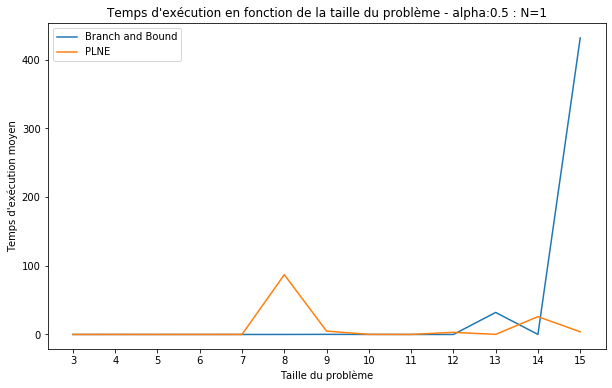

In [91]:
N = 1 #Nombre d'échantillons
n = 20 #Taille maximum du problème
alpha = 0.5

resultats_PLNE = [[] for i in range(3,n)]
resultats_BB = [[] for i in range(3,n)]

for _ in range(N):
    for i in range(3,n):
        p,d,w = genInstancies(i,alpha)
                
        start = time.time()
        _, _, _, _, _ = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
        end = time.time()
        
        resultats_BB[i-3].append(end-start)
        
        solveTimePLNE, _, _ = plne_Ordonnancement(p,d,w)
        
        resultats_PLNE[i-3].append(solveTimePLNE)
        
resultats_BB = [np.mean(res) for res in resultats_BB]
resultats_PLNE = [np.mean(res) for res in resultats_PLNE]
resultats_BB = np.array(resultats_BB)
resultats_PLNE = np.array(resultats_PLNE)


plt.figure(figsize=(10,6))
X = list(range(3,n))
plt.plot(X,resultats_BB,label="Branch and Bound")
plt.plot(X,resultats_PLNE,label="PLNE")
plt.xlabel("Taille du problème")
plt.xticks(X)
plt.ylabel("Temps d'exécution moyen")
plt.title("Temps d'exécution en fonction de la taille du problème - alpha:{} : N={}".format(alpha,N))
plt.legend()
plt.savefig('PERF_PLNE_BB.png')

__Résultat :__ la résolution du problème via l'algorithme de Branch & Bound se fait bien plus rapidmeent qu'avec le PLNE. 

Text(0.5, 1.0, "Temps d'exécution en fonction de la taille du problème - alpha:0.5 : N=1")

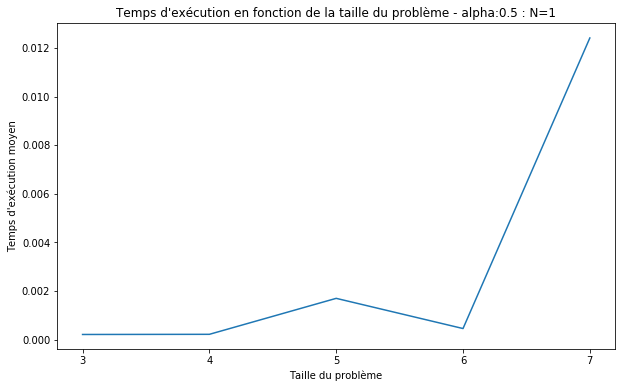

In [84]:
N = 1 #Nombre d'échantillons
n = 8 #Taille maximum du problème
alpha = 0.5

resultats_BB = [[] for i in range(3,n)]

for _ in range(N):
    for i in range(3,n):
        p,d,w = genInstancies(i,alpha)
                
        start = time.time()
        _, _, _, _, _ = branch_and_bound(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
        end = time.time()
        
        resultats_BB[i-3].append(end-start)
        

resultats_BB = [np.mean(res) for res in resultats_BB]
resultats_BB = np.array(resultats_BB)



plt.figure(figsize=(10,6))
X = list(range(3,n))
plt.plot(X,resultats_BB)
plt.xlabel("Taille du problème")
plt.xticks(X)
plt.ylabel("Temps d'exécution moyen")
plt.title("Temps d'exécution en fonction de la taille du problème - alpha:{} : N={}".format(alpha,N))

__Résultats :__ Bien que performante par rapport aux autres approches, notre fonction _Brand and Bound_ utilisée avec la méthode 2 (remplissage par la fin), $getDual\_3$ (Notre meilleure méthode de calcul de bornes duales) et $getPrimal\_2$ (Notre meilleure méthode de calcul de bornes primales) se retrouve rapidement "bloquée" sur des problèmes de taille importante. Pour des problèmes avec 15 pièces à usiner, il n'est pas rare de dépasser la minute de temps d'exécution. Notre problème d'ordonnancement est un problème NP-Difficile et il n'est pas étonnant de le voir exploser en temps aussi rapidement.

## Visualisation de l'arbre de branchement.

L'idée est ici d'implémenter une fonction de visualisation de l'arbre de branchement. 

### Redéfinition de quelques éléments de structure

Comme évoqué aupravant, nous changeons les index des noeuds. Nous sommes conscients que stocker des entiers est moins couteux en temps de calcul que stocker des grandes chaines de caractères et c'est pour cette raison que nous avons fait une nouvelle version de la fonction branch and bound ci dessous. 

Afin de mieux comprendre notre facon d'indexer les noeuds, nous présentons un exemple succinct. 

![Arbre de branchement](EX1.png)

* Le noeud racine sera __P__
* Le noeud __P(1)__ signifie que la solution liée à ce noeud place l'usinage de la pièce 1 en dernier.
* Le noeud __P(2,1)__ signifie que la solution liée à ce noeud place l'usinage de la pièce 1 en dernier, puis celui de la pièce 2 en avant dernier.

Pour des exmples de taille plus conséquente (+ de taches), par exemple 5, certains des noeuds seront instanciés par __P(*4 chiffres séparés par des virgules*)__.

### Branch and bound redéfini

Nous utilisons ces nouvelles indexations pour mettre à jour la fonction branch and bound. 

Notons aussi que nous ajoutons quelques élements de code permettant de trouver la branche de l'arbre qui aura donné lieu à la meilleure solution. Pour cela, nous localisons le meilleur noeud, i.e le noeud qui :
* est tel que la borne duale du noeud est inférieure ou égale à la borne primale du problème                **(1)**
* est tel que la borne duale du noeud est plus grande que n'importe quel borne duale des noeuds vérifiant (1).

Nous remontons ensuite (en utilisant les parents) afin d'obtenir la branche de l'arbre donnant lieu à la meilleure solution. Cela nous sera utile lors de la visualisation de l'arbre de branchement.

Les éléments retournés par la fonction sont également ajustés. Nous ajoutons le retour de : 
* __branch__ : la branche donnant lieu à la solution optimale du problème
* __Tree__: l'arbre correspondant au problème

In [ ]:
def arborescence_display(node,Tree):
    branch = []
    while node.parent != None:
        branch.append(node.idx)
        node = node.parent
    branch.append(node.idx)
    
    return branch

In [ ]:
def branch_and_bound_display(p,d,w,byLast,getPrimal,getDual,exploration):
    
    Tasks = list(range(len(p)))
    Tree = [] # list of all nodes created (a list of Node objects)
    Queue = [] # list of nodes to process (a list of integers with the index of nodes to process in the Tree)
    LB = 0 # we set the lower bound to a sufficiently small number 
    
    UB,currentOrder = getPrimal(p,d,w)

    bestNode = Node("",-1, [], 0 ,[])
    
    root = Node("P",None, [], 0, []) # at the root node no variables are fixed 
    Tree.append(root) # start the tree with the root node
    Queue.append(0) # start the list of nodes to process with the root node
    
    #continue processing nodes until the queue is empty
    
    nbIterations = 0
    
    while Queue!=[]:
        
        # process the first node in the queue

        currentIndex = exploration(Queue,None,None)
        currentNode = Tree[currentIndex]
        nbIterations +=1
        
        if currentNode.lb < UB:
            
            if len(currentNode.visited) == len(p):
                order = currentNode.visited.copy()
                if byLast:
                    order.reverse()
                solutionCost = computeCost(p,d,w,order)
                if solutionCost <= UB:
                    UB = solutionCost
                    currentOrder = order
                    bestNode = currentNode
            else:
                for nextTask in (set(Tasks)-set(currentNode.visited)):
                    nextVisited = currentNode.visited.copy()
                    nextVisited.append(nextTask)
                    nextLb = getDual(p,d,w, nextVisited)

                    newNode = Node("",currentNode, [], nextLb,nextVisited)
                    #Creating good labels for each node :
                    if currentNode.visited!=[]:
                        newNode.idx="P("
                        for i in range(len(nextVisited)-1):
                            newNode.idx+=str(nextVisited[i])+","
                        newNode.idx+=str(nextVisited[len(nextVisited)-1])+")"
                    else:
                        newNode.idx="P("+str(nextTask)+")"
                        
                    Tree.append(newNode)
                    Queue.append(len(Tree)-1)
                    currentNode.children.append(newNode)
            
        # When the processing of the node is completed remove the node from the queue     
        Queue.remove(currentIndex)

    # return the  solution
    
    if 2*(UB-bestNode.lb)<=0.0001:
        branch = arborescence_display(bestNode,Tree)
    else:
        bestLB = -math.inf
        for node in Tree:
            if node.lb > bestLB and node.lb <=UB:
                bestLB = node.lb
                bestNode=node
        branch = arborescence_display(bestNode,Tree)

    return UB, currentOrder, nbIterations, branch, Tree

### Fonction d'affichage de l'arbre

Nous implémentons à présent une fonction d'affichage de l'arbre. Cette méthode utilise différents élements de packages spécifiques (importés au préalable, et non utilisés jusqu'alors). Nous utilisons :
* __networkx__ afin de crééer une structure d'arbre facile d'utilisation et facile à représenter.
* __pydot__ qui permettra de visualiser simplement l'abre de branchement.

La méthode consiste principalement à reconstitué l'arbre de branchement à partir de la liste de Noeud __Tree__. De l'afficher de manière adequat, et de mettre en évidence la branche donnant lieu à la solution optimale.

In [ ]:
def displayTree(Tree,currentOrder,branch,byLast):
    
    #Utilisation de networkx : création d'un graphe a partir de la liste Tree
    index=['P']
    parent=['P']
    for node in Tree:
        if(node.idx!="P"):
            index.append(node.idx)
            parent.append((node.parent).idx)
    graphe=dict(zip(index,parent))
    
    graph=nx.Graph()
    graph.add_nodes_from(index)
    for idx in graphe.keys():
        graph.add_edge(idx,graphe[idx])
        
    if(byLast==True):
        branch.reverse()

    bestPath= set(zip(branch[:-1], branch[1:]))
    
    #Gestion des couleurs :
    edge_colors=dict()
    for edge in graph.edges():
        if edge in bestPath:
            edge_colors[edge]='red'
        else:
            edge_colors[edge]='lightblue'
            
    node_colors=dict()
    for node in graph.nodes():
        if node in branch:
            node_colors[node]='red'
        else:
            node_colors[node]="lightblue"
            
    #Affichage : 
    plt.figure(figsize=(12,8))
    pos = graphviz_layout(graph, prog="dot")
    nx.draw(graph, pos,with_labels=True,node_size=1200,node_color=node_colors.values(),edge_color=edge_colors.values())
    plt.show()

### Test de la fonction d'affichage

Nous effectuons le test de notre fonction d'affichage. Pour cela, nous prenons différents problèmes. Dans un premier temps, nous utiliserons l'exemple de TD (*EX7 TD Branch and bound*). Nous comparons ensuite l'abre de branchement affiché à celui obtenu lors de la résolution du branch and bound en TD.

In [ ]:
#Textbook Example
pj = [12,8,15,9]
dj = [16,26,25,27]
wj = [4,5,3,5]

In [ ]:
solution,order,nbIterations,branch,Tree=branch_and_bound_display(pj,dj,wj, True, getPrimal_2, getDual_2,exploration_0)
displayTree(Tree,order,branch,True)

__Commentaires :__ nous voyons ici les noeuds ayant donné lieu à des élagages et la branche ayant donné lieu à la solution optimale. Les noeuds P(0), P(1), et P(3) on donné lieu à des élagages. Les noeuds P(2,0) et P(2,1) également. Le noeud P(2,3) a quant a lui permis de trouver la solution optimale puisque sa borne duale vaut la borne primale du problème (67).

*Notons que cette visualisation n'a de sens que si le nombre d'objets à usiner n'est pas trop élevé. Un nombre élevé d'objets donnera souvent lieu à un nombre d'itérations élevées et donc l'arbre de branchement sera gigantesque (et illisible).*

On teste de nouveau la visualisation sur des instances générées aléatoirement.

In [ ]:
p,d,w = genInstancies(4,.5)
print("p : ", p)
print("d : ", d)
print("w : ", w)
solution, order, nbIterations,branch,Tree = branch_and_bound_display(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
print("Final Results: {} Iterations".format(nbIterations))
print("Order : {} | Cost : {}".format(order,computeCost(p,d,w,order)))
print(branch)
displayTree(Tree,order,branch,True)

In [ ]:
p,d,w = genInstancies(6,.5)
print("p : ", p)
print("d : ", d)
print("w : ", w)
solution, order, nbIterations,branch,Tree = branch_and_bound_display(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
print("Final Results: {} Iterations".format(nbIterations))
print("Order : {} | Cost : {}".format(order,computeCost(p,d,w,order)))
print(branch)
displayTree(Tree,order,branch,True)

In [ ]:
p,d,w = genInstancies(8,.5)
print("p : ", p)
print("d : ", d)
print("w : ", w)
solution, order, nbIterations,branch,Tree = branch_and_bound_display(p,d,w, True, getPrimal_2, getDual_2,exploration_1)
print("Final Results: {} Iterations".format(nbIterations))
print("Order : {} | Cost : {}".format(order,computeCost(p,d,w,order)))
#print(branch)
displayTree(Tree,order,branch,True)

# Pour aller plus loin

Nous allons ci-dessous tenter de résoudre quelques problèmes annexes à notre problème de base.